# Analyze data

In [ ]:
import json
import os
import numpy as np
import pandas as pd
from datetime import date

from pandas.api.types import CategoricalDtype

import seaborn as sns
import matplotlib.pyplot as plt

## load data

In [ ]:
datafile = f'cleaned_{date.today()}.csv'

# check if datafile is most up-to-date
[print('not using the latest data') for file in os.listdir() if (file.startswith('combined') & (datafile < file))]

df = pd.read_csv(datafile).astype({'n': int, 'parkrun': 'category', 'state': 'category', 'gender': 'category', 'agegroup': CategoricalDtype(ordered=True)})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813965 entries, 0 to 1813964
Data columns (total 7 columns):
 #   Column    Dtype   
---  ------    -----   
 0   name      object  
 1   n         int64   
 2   parkrun   category
 3   state     category
 4   gender    category
 5   agegroup  category
 6   time      float64 
dtypes: category(4), float64(1), int64(1), object(1)
memory usage: 50.2+ MB


## relative difference per parkrun with overall PB for each individual

In [ ]:
# relative difference between fastest and current parkrun per name/gender/agegroup
df['PB'] = df.groupby(['name','gender','agegroup'])['time'].transform(min)
df['rel_diff'] = (df.time-df.PB)/df.PB

tmp1 = df.groupby('parkrun').rel_diff.agg(['median','mean','std'])
tmp1['n'] = df.groupby('parkrun').n.sum()
tmp1

,median,mean,std,n
parkrun,,,,
Airlie Beach,0.052330,0.108823,0.178539,17576
Albert Melbourne,0.000000,0.063931,0.148361,111914
Albury Wodonga,0.000000,0.052398,0.151063,49871
Aldinga Beach,0.030850,0.109672,0.199230,10776
Altona Beach,0.000000,0.073890,0.172590,25802
...,...,...,...,...
Yeppoon,0.030099,0.098707,0.178983,9992
Yokine,0.011580,0.079247,0.166178,19536
You Yangs,0.084053,0.157091,0.238870,6515


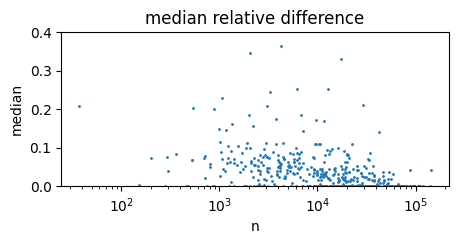

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp1.plot.scatter(ax = ax, x = 'n', y = 'median', s = 1)
ax.set(xscale = 'log', ylim = [0,0.4], title = 'median relative difference');

Median relative difference is not a good metric since many people do only one parkrun, and so their parkrun PB will be set at this course. This means the median relative difference is 0. Let's exclude runners who have only done one parkrun. 

In [ ]:
# exclude runners with one parkrun only
freq = df.value_counts(['name','gender','agegroup'])
df = df.set_index(['name','gender','agegroup']).loc[freq[freq>1].index].reset_index()

tmp2 = df.groupby('parkrun').rel_diff.agg(['median','mean','std'])
tmp2['n'] = df.groupby('parkrun').n.sum()

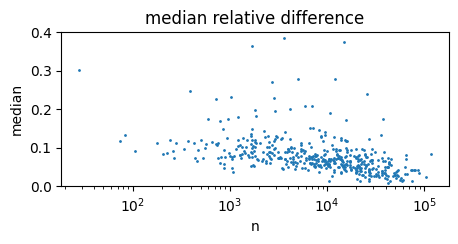

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp2.plot.scatter(ax = ax, x = 'n', y = 'median', s = 1)
ax.set(xscale = 'log', ylim = [0,0.4], title = 'median relative difference');

Now at least we don't have all parkruns centered at zero. We do however see big differences. Potentially, some of these parkruns are considered as fun runs, and presumably not run all out. Let's assume that for an all out effort, we expect to be at least within a certain percentage of our PB.

Considering famous parkrunner Aidan Hobbs (holder of 24 courserecords) with PB of 14.34 (30-34) and 14.16 (35-39), this means we expect that he should be able to run under 16.00 (30-34) and 15.40 (35-39) on any course. And only when we have done so, we consider this as an all-out effort that we can use to do compare across parkruns.

Even so, Aidan Hobbs will not go all out at every parkrun he runs. For instance, he can decide to break the course record and once that's in the bag, not push much further. On the other hand, when we has competition, he might go superfast. In Sandgate 18 June 2022, 13 guys went under 15 minutes, so they must have all pushed each other resulting in a supersharp course record by Kieran Perkins (14.14) and a similarly sharp time by Aidan Hobbs (14.16).

In [ ]:
df.query('name == "Aidan HOBBS"').sort_values('time').head(10)

,name,gender,agegroup,n,parkrun,state,time,PB,rel_diff
591137,Aidan HOBBS,M,35-39,1,Sandgate,NSW,14.266667,14.266667,0.000000
83085,Aidan HOBBS,M,30-34,2,Sandgate,NSW,14.566667,14.566667,0.000000
83075,Aidan HOBBS,M,30-34,4,Mitchelton,QLD,14.683333,14.566667,0.008009
591139,Aidan HOBBS,M,35-39,3,Woy Woy,NSW,14.750000,14.266667,0.033879
83093,Aidan HOBBS,M,30-34,1,Wynnum,QLD,14.783333,14.566667,0.014874
591135,Aidan HOBBS,M,35-39,1,Aplins Weir,QLD,14.850000,14.266667,0.040888
83083,Aidan HOBBS,M,30-34,20,Rocks Riverside,QLD,14.933333,14.566667,0.025172
83071,Aidan HOBBS,M,30-34,6,Kedron,QLD,15.000000,14.566667,0.029748
83086,Aidan HOBBS,M,30-34,7,South Bank,QLD,15.083333,14.566667,0.035469
83064,Aidan HOBBS,M,30-34,1,Bargara,QLD,15.116667,14.566667,0.037757


In [ ]:
df2 = df.query('rel_diff <= 0.1')

tmp3 = df2.groupby('parkrun').rel_diff.agg(['median','mean','std'])
tmp3['n'] = df2.groupby('parkrun').n.sum()

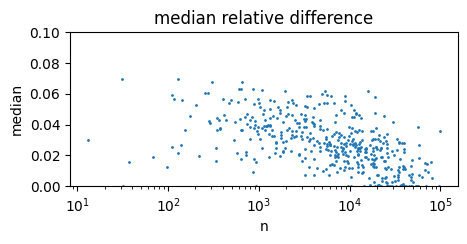

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp3.plot.scatter(ax = ax, x = 'n', y = 'median', s = 1)
ax.set(xscale = 'log', ylim = [0,0.1], title = 'median relative difference');

This gives a decent spread betweeen parkruns, and no real outliers (which we have of course selected for by only including times within 10% of ones PB). A median of zero means that more than half of the included runners have set their parkrun PB at this particular parkrun. Since there are many parkruns with median 0, let's consider the mean relative difference from a PB next.

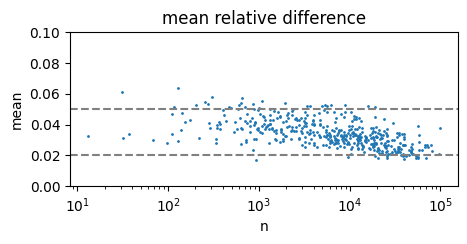

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp3.plot.scatter(ax = ax, x = 'n', y = 'mean', s = 1)
ax.set(xscale = 'log', ylim = [0,0.1], title = 'mean relative difference');
[ax.axhline(val, ls = '--', c = 'gray') for val in [0.02, 0.05]];

This tightens the distribution of parkruns further, and does allow to make some distinction between parkruns. The fastest ones seem to have an average relative difference of 2%, meaning that on average, runners set a time 2% off their PB. 

The parkrun with smallest mean relative difference is Picton with 0.0168, which seem to be an outlier since all other parkruns with such a low mean relative difference have a participants in the order $10^4 - 10^5$. It could be that local parkruns with high attendance in urban areas are people's "main run" where do they really well, and where their PB approaches their max effort, whilst in other parkuns they may have tried only times, and not achieved a comparable 'max-effort' PB for whatever reason (not well rested, more difficult conditions, 'just for fun' mindset, etc.)

To test whether with this hypothesis we can remove some of the dependence of the mean relative difference on the number of runners in an event, we only include races where a parkrunner has participated at least twice. We may want to revisit the less than 0.1 mean relative difference, because these factors may be related. 

In [ ]:
df3 = df.query('n > 1 and rel_diff <= 0.2')

# recheck whether parkrunners have competed in 2 or more events with above criteria on n and rel_diff
freq = df3.value_counts(['name','gender','agegroup'])
df3 = df3.set_index(['name','gender','agegroup']).loc[freq[freq>1].index].reset_index()

df3.PB = df3.groupby(['name','gender','agegroup']).time.transform(min).values
df3.rel_diff = (df3.time-df3.PB)/df3.PB

tmp4 = df3.groupby('parkrun').rel_diff.agg(['median','mean','std'])
tmp4['n'] = df3.groupby('parkrun').n.sum()

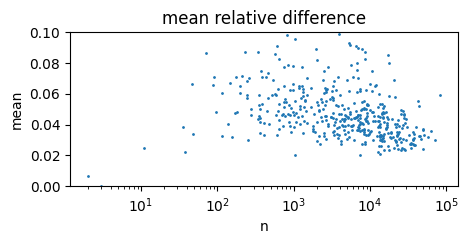

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp4.plot.scatter(ax = ax, x = 'n', y = 'mean', s = 1)
ax.set(xscale = 'log', ylim = [0,0.1], title = 'mean relative difference');

## Colour by state

In [ ]:
with open('states.json','r') as f:
    locations = json.load(f)
tmp3['state'] = tmp3.index.map(locations)

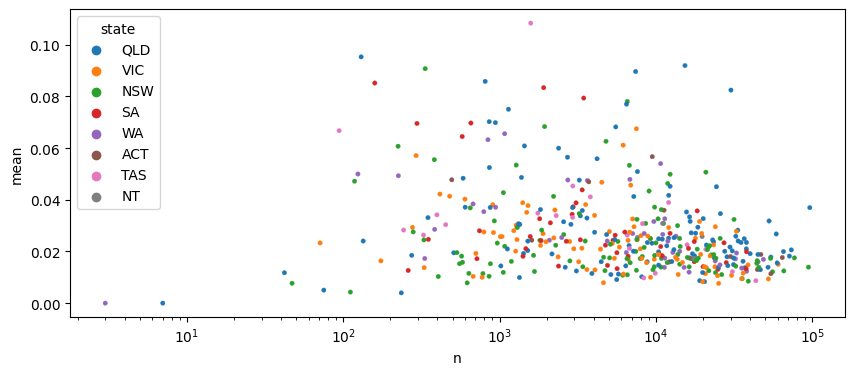

In [ ]:
fig, ax = plt.subplots(figsize = (10,4))
sns.scatterplot(ax = ax, data = tmp3.reset_index(), x = 'n', y = 'mean', hue = 'state', edgecolor = None, s = 10)
ax.set(xscale = 'log');

<seaborn.axisgrid.FacetGrid>

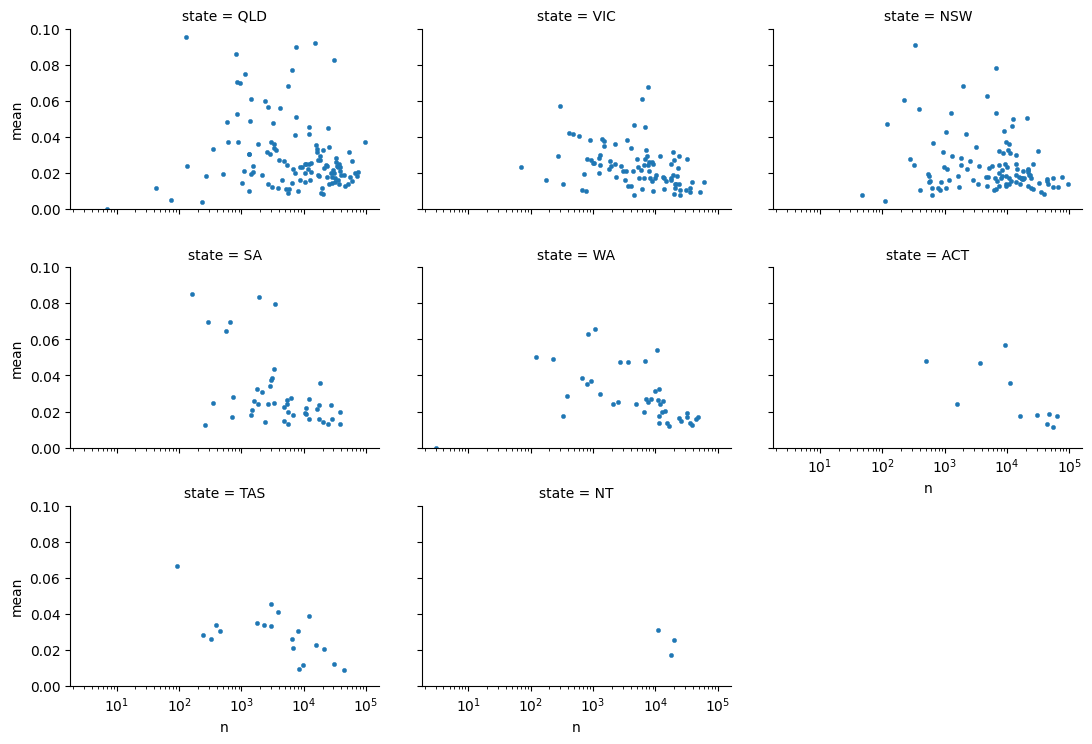

In [ ]:
g = sns.relplot(data = tmp3.reset_index(), x = 'n', y = 'mean', col = 'state', col_wrap = 3, edgecolor = None, s = 10, height = 2.5, aspect = 1.5)
g.set(xscale = 'log', ylim = [0,0.1])

## Per age group

In [ ]:
tmp5 = df3.groupby(['agegroup', 'parkrun']).rel_diff.agg(['median','mean','std'])
tmp5['n'] = df3.groupby(['agegroup','parkrun']).n.sum()

<seaborn.axisgrid.FacetGrid>

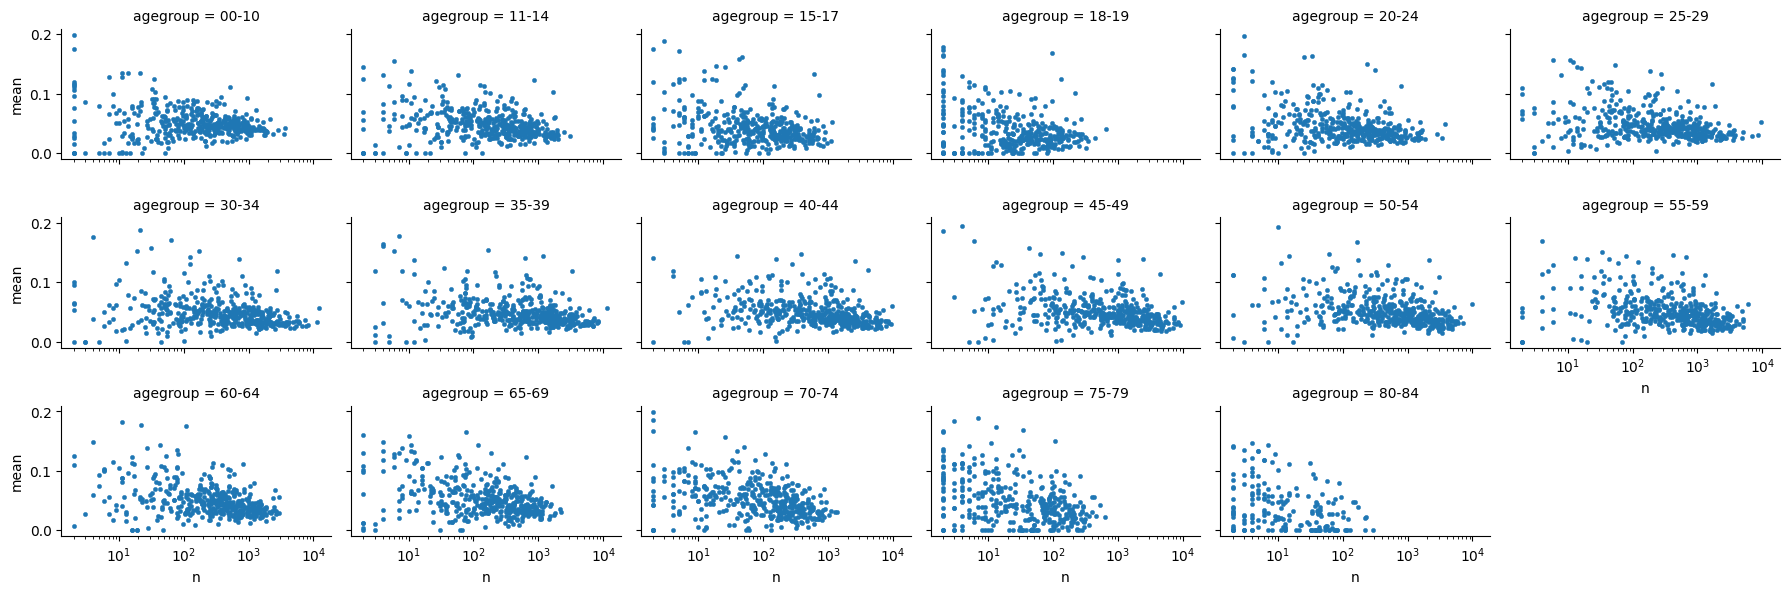

In [ ]:
g = sns.relplot(data = tmp5.reset_index(), x = 'n', y = 'mean', col = 'agegroup', col_wrap = 6, edgecolor = None, s = 10, height = 2, aspect = 1.5)
g.set(xscale = 'log')

## Per PB group
(0, 20, 25, 30, 35, 45, 60)

In [ ]:
df3['pbgroup'] = pd.cut(df3.PB, bins = [0, 20, 25, 30, 35, 45, 60], labels = ['00-20','20-25', '25-30', '30-35', '35-45', '45-60'])

tmp6 = df3.groupby(['pbgroup', 'parkrun']).rel_diff.agg(['median','mean','std'])
tmp6['n'] = df3.groupby(['pbgroup','parkrun']).n.sum()

<seaborn.axisgrid.FacetGrid>

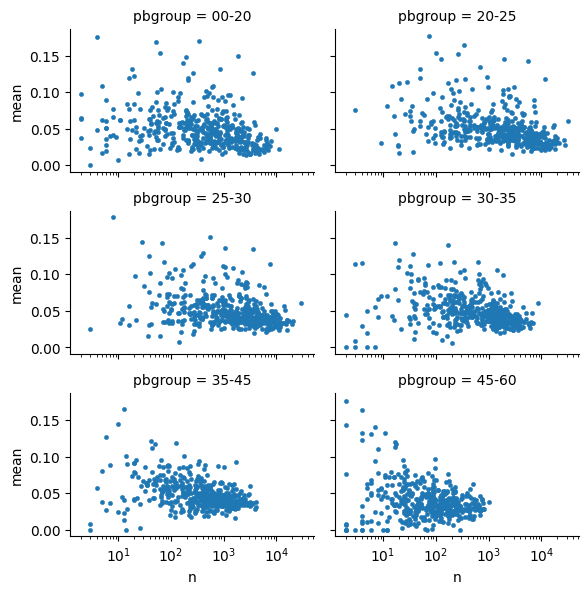

In [ ]:
g = sns.relplot(data = tmp6.reset_index(), x = 'n', y = 'mean', col = 'pbgroup', col_wrap = 2, edgecolor = None, s = 10, height = 2, aspect = 1.5)
g.set(xscale = 'log')

## Measure by rank

In [ ]:
df3['rank'] = df3.groupby(['name','gender','agegroup'])['time'].rank(pct = True)

tmp7 = df3.groupby('parkrun')['rank'].agg(['median','mean','std'])
tmp7['n'] = df3.groupby('parkrun').n.sum()

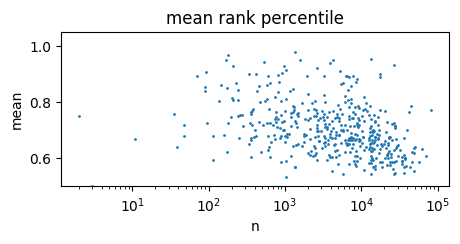

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5,2))
tmp7.plot.scatter(ax = ax, x = 'n', y = 'mean', s = 1)
ax.set(xscale = 'log', ylim = [0.5,1.05], title = 'mean rank percentile');

In [ ]:
tmp7.sort_values('mean').head(50)

,median,mean,std,n
parkrun,,,,
Montrose Foreshore,0.500000,0.497863,0.271514,7280
Dobbyn Park,0.500000,0.500000,NaN,3
Whalan Reserve,0.500000,0.534259,0.283791,1019
Kedron,0.500000,0.542535,0.291033,26928
Gatton,0.500000,0.542667,0.267203,13228
Greenbank,0.500000,0.543757,0.301032,5788
North Lakes,0.500000,0.546956,0.275108,36726
Maribyrnong,0.500000,0.547729,0.270234,27773
Lake Mac,0.500000,0.555034,0.264992,49337


In [ ]:
tmp7.loc[['St Peters','Rhodes','Curl Curl']]

,median,mean,std,n
parkrun,,,,
St Peters,0.666667,0.700325,0.269391,39491
Rhodes,0.500000,0.602480,0.280697,34339
Curl Curl,0.500000,0.574619,0.260123,23571


In [ ]:
df3.sort_values('PB').head(20)

,name,gender,agegroup,n,parkrun,state,time,PB,rel_diff,pbgroup,rank
676559,Jude THOMAS,M,18-19,14,Ipswich QLD,QLD,15.716667,14.033333,0.119952,00-20,0.750
676560,Jude THOMAS,M,18-19,2,Kedron,QLD,14.033333,14.033333,0.000000,00-20,0.250
676562,Jude THOMAS,M,18-19,2,Rocks Riverside,QLD,15.116667,14.033333,0.077197,00-20,0.500
676558,Jude THOMAS,M,18-19,4,Ecco Ripley,QLD,16.400000,14.033333,0.168646,00-20,1.000
763425,Riley COCKS,M,20-24,2,Pakapakanthi,SA,14.300000,14.300000,0.000000,00-20,0.500
763426,Riley COCKS,M,20-24,2,Torrens,ACT,14.583333,14.300000,0.019814,00-20,1.000
204697,Kieren PERKINS,M,25-29,4,New Farm,QLD,14.850000,14.350000,0.034843,00-20,0.375
204695,Kieren PERKINS,M,25-29,10,Mitchelton,QLD,16.183333,14.350000,0.127758,00-20,0.875
204702,Kieren PERKINS,M,25-29,2,South Bank,QLD,15.133333,14.350000,0.054588,00-20,0.500
204692,Kieren PERKINS,M,25-29,9,Kedron,QLD,14.350000,14.350000,0.000000,00-20,0.125
